# Objective: Visualising Amazon fine food reviews using TSNE

##### NOTE - I am not explaning any techiques and methods as it can be easily available online

In [1]:
# importing library

import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cross_validation import train_test_split # for spliting dataset
from sklearn.feature_extraction.text import CountVectorizer # bow-->1gram and 2 gram
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from gensim.models import Word2Vec  # w2v
from gensim.models import KeyedVectors # to understanding w2v using google pre trained model
from sklearn.metrics import accuracy_score # to check the accuracy of model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score # k-fold cv
from sklearn.metrics import classification_report

/home/adityaadarsh99/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
# remove '#' sign to download data-set
#!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3575.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/kaggle-datasets/18/2157/Reviews.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1539455264&Signature=sUXQz0kX2395nqKOQppw23fSVbEPjFPhNtI1TC5FN1fOhx8RBGKLP1d1UZgiftoI1XI3TLxlFu6JwY%2BL7LwhxM46VQp89iJ%2BJZ8PaaY%2F61q8y%2BVchuDT8v4UnmbJ5%2Bkvf77HaNiJrAcqSY1K0C66npHhhaAgMzmvHJtTOnpZ70LFbZ6g1X%2Bh%2Ba2Tmkuiae%2F3CVIjnkE7sO2X4l3o5x4H45gu3EWzyrlqWJDwx0EJmDbnsOCsCzIEie7in70HwkDOwxGq9WdCGscFlFVDfd8W%2BV00yUfT82%2F2%2F4H4WGrnvI0uxFECct3b0n1F%2BbACM0sO0gvmmXAZNgbeOIpsUAclRw%3D%3D" -O "Reviews.csv.zip" -c

In [ ]:
# remove '#' sign to unzip the dataset
"""import zipfile
data=zipfile.ZipFile("Reviews.csv.zip")
data.extractall()"""

>   # Loading the dataset

In [2]:
#loading the amazon dataset
dataset=pd.read_csv("Reviews.csv")

In [3]:
print(dataset.shape)
dataset.head()


(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


> # preprocessing the data

In [4]:
# sorting the value
dataset.sort_values(by='Id',inplace=True )
#finding the dublicate values using 'df.dublicated'
dataset[dataset.duplicated(subset={'ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'})].shape
#alternate way to drop dublicate values
dataset_no_dup=dataset.drop_duplicates(subset={'ProfileName','Score','Time','Summary'},keep='first')
print(f"before {dataset.shape}")
print(f"after removing duplicate values-->shape = {dataset_no_dup.shape}")
# %age of no. of review reamin in data set
(dataset_no_dup.size/dataset.size)*100

# removing reviews where "HelpfulnessNumerator>HelpfulnessDenominator"
dataset_no_dup=dataset_no_dup[dataset_no_dup['HelpfulnessNumerator']<=dataset_no_dup['HelpfulnessDenominator']]


before (568454, 10)
after removing duplicate values-->shape = (393141, 10)


In [5]:
# taking reviews whose score is not equal to 3
filtered_dataset=dataset_no_dup[dataset_no_dup['Score']!=3]
filtered_dataset.shape
#creating a function to filter the reviews (if score>3 --> positive , if score<3 --> negative)
def partition(x):
    if x>3:
        return 'positive'
    else:
        return 'negative'

score=filtered_dataset['Score']
pos_neg=score.map(partition)
filtered_dataset['Score']=pos_neg
print(filtered_dataset.shape)
filtered_dataset.head()


(363393, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# changing the format of timestamp to ('%Y-%m-%d %H:%M:%S'

import time
import datetime
time=[]
for timestamp in filtered_dataset['Time']:
    t=datetime.datetime.fromtimestamp(timestamp).strftime(('%Y-%m-%d %H:%M:%S'))
    time.append(t)
filtered_dataset['time']=time   

In [7]:
# sort by time
filtered_dataset.sort_values(by='time',inplace=True)

In [8]:

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

sno = nltk.stem.SnowballStemmer('english')#snowball stemmer

stop=set(stopwords.words('english')) #set of stopwords

#clean html tags
def cleanhtml(sent):
    pattern=re.compile(r'<.*?>')
    cleansent=re.sub(pattern," ",sent)
    return cleansent

#cleean punctuation
def cleanpunc(word):
    clean_punc=re.sub(r'[?|!|\'|"|#]',' ',word)
    clean_punc=re.sub(r'[.|,|)|(|\|/]',' ',clean_punc)
    return clean_punc

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adityaadarsh99/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
import string

x=0 # number of reviews you want to clean/pre-processed
positive_words=[]
negative_words=[]
str1=''
final_sent=[] # storing the list of final pre-processed sentences
i=0

for sent in filtered_dataset["Text"]:
    sent=cleanhtml(sent) #removing html tags
    filtered_sentence=[]
    for w in sent.split():
        for clean_words in cleanpunc(w).split():
            if((len(clean_words)>2) & (clean_words.isalpha())):
                if (clean_words.lower() not in stop):
                    s=(sno.stem(clean_words.lower()))
                    filtered_sentence.append(s)
                    if (filtered_dataset['Score'].values[i]=='positive'):
                        positive_words.append(s)
                    if (filtered_dataset['Score'].values[i]=='negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1=" ".join(filtered_sentence) #str of all the cleaned words
    final_sent.append(str1) # appending cleaned words to sentence
    i=i+1
          

In [10]:
print(len(final_sent))
print("\nBefore cleaning :\n",filtered_dataset["Text"][10])
print(f"\nAfter cleaning :\n {final_sent[10]}")



363393

Before cleaning :
 I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!

After cleaning :
 get crazi realli imposs today find french vhs version film could pleas tell someth tks


In [11]:
filtered_dataset['cleaned_text']=final_sent
print(filtered_dataset.shape)
filtered_dataset.head()

(363393, 12)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,time,cleaned_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1999-10-08 03:00:00,witti littl book make son laugh loud recit car...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1999-10-25 03:00:00,rememb see show air televis year ago child sis...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,1999-12-02 03:00:00,beetlejuic well written movi everyth excel act...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",1999-12-06 03:00:00,twist rumplestiskin captur film star michael k...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,2000-01-03 03:00:00,beetlejuic excel funni movi keaton hilari wack...


In [12]:
# splitting the dataset in train and test

n=filtered_dataset.shape[0]
train=filtered_dataset.iloc[:round(0.70*n),:]
test=filtered_dataset.iloc[round(0.70*n):,:]

In [13]:
print(train.shape)
print(test.shape)

(254375, 12)
(109018, 12)


In [14]:
'''# saving train and test dataset using pickle for fututre use

file=open("train.pkl","wb")
pickle.dump(train,file)
file.close()

file=open("test.pkl",'wb')
pickle.dump(test,file)
file.close()'''

In [5]:
#loading train and test dataset

file=open("train.pkl","rb")
train=pickle.load(file) # loading 'train' dataset

file=open("test.pkl",'rb')
test=pickle.load(file) # loading 'train' dataset


# Text Featurization (converting reviews text into vectors)

## 1. Bag of word

### a. unigram bow

In [48]:
# one gram-BOW from "sklean.feature_extraction.text.CountVectorizer"
count_vect=CountVectorizer()
train_bow=count_vect.fit_transform(train['cleaned_text'])
test_bow=count_vect.transform(test['cleaned_text'])

In [3]:
# saving train_bow and test_bow dataset using pickle for fututre use

'''file=open("train_bow.pkl","wb")
pickle.dump(train_bow,file)
file.close()

file=open("test_bow.pkl",'wb')
pickle.dump(test_bow,file)
file.close()
'''

#loading train_bow and test _bow
file=open('train_bow.pkl','rb')
train_bow=pickle.load(file)

file=open('test_bow.pkl','rb')
test_bow=pickle.load(file)

In [18]:
print("train_bow",train_bow.shape)
print("test_bow",test_bow.shape)


train_bow (254375, 58042)
test_bow (109018, 58042)


### b. bigram bow


In [19]:
# bi-gram_BOW 
count_vect_gram=CountVectorizer(ngram_range=(1,2))
train_bow_2gram=count_vect_gram.fit_transform(train['cleaned_text'])
test_bow_2gram=count_vect_gram.transform(test['cleaned_text'])

In [4]:
# saving train_bow_2gram and test_bow_2gram dataset using pickle for fututre use

'''file=open("train_bow_2gram.pkl","wb")
pickle.dump(train_bow_2gram,file)
file.close()

file=open("test_bow_2gram.pkl",'wb')
pickle.dump(test_bow,file)
file.close()
'''

#loading train_bow_2gram and test _bow_2gram
file=open('train_bow_2gram.pkl','rb')
train_bow_2gram=pickle.load(file)

file=open('test_bow_2gram.pkl','rb')
test_bow_2gram=pickle.load(file)

In [65]:
print("train_bow_2gram",train_bow_2gram.shape)
print("test_bow_2gram",test_bow_2gram.shape)


train_bow_2gram (254375, 2273361)
test_bow_2gram (109018, 58042)


## 2. TF-IDF

In [8]:
# tf-idf "from sklearn.feature_extraction.text.TfidfVectorizer"
tf_idf=TfidfVectorizer()
train_tf_idf=tf_idf.fit_transform(train['cleaned_text'])
test_tf_idf=tf_idf.transform(test['cleaned_text'])

In [5]:
# saving train_tf_idf and test_tf_idf dataset using pickle for fututre use

'''file=open("train_tf_idf.pkl","wb")
pickle.dump(train_tf_idf,file)
file.close()

file=open("test_tf_idf.pkl",'wb')
pickle.dump(test_tf_idf,file)
file.close()
'''

#loading train_tf_idf and test_tf_idf
file=open('train_tf_idf.pkl','rb')
train_tf_idf=pickle.load(file)

file=open('test_tf_idf.pkl','rb')
test_tf_idf=pickle.load(file)

## 3. avg w2v

In [13]:
# converting our text-->vector using w2v with 50-dim
# more the dimension of each word = better the semantic of word
# using lib from "gensim.models.Word2Vec"
# to run w2v we need list of list of the words as w2v covert each world into number of dim


# for train_w2v
list_of_sent_train=[]
for sent in train['cleaned_text'].values:
    list_of_sent_train.append((str(sent)).split())
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50)

# vocablary of w2v model of amazon dataset
vocab=w2v_model.wv.vocab
len(vocab)

#-------------------------------------------------------------------------------------------------

# for test_w2v
list_of_sent_test=[]
for sent in test['cleaned_text'].values:
    list_of_sent_test.append((str(sent)).split())


In [14]:
'''
    -->procedure to make avg w2v of each reviews
    1. find the w2v of each word
    2. sum-up w2v of each word in a sentence
    3. divide the total w2v of sentence by total no. of words in the sentence
'''

# average Word2Vec
# compute average word2vec for each review.
train_w2v = []; # the avg-w2v for each sentence/review in train dataset is stored in this list

for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v.append(sent_vec)

print(len(train_w2v))

#-----------------------------------------------------------------------------------

test_w2v = []; # the avg-w2v for each sentence/review in test dataset is stored in this list

for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v.append(sent_vec)

print(len(test_w2v))

254375
109018


In [6]:
# saving train_w2v and test_w2v dataset using pickle for fututre use

'''file=open("train_w2v.pkl","wb")
pickle.dump(train_w2v,file)
file.close()

file=open("test_w2v.pkl",'wb')
pickle.dump(test_w2v,file)
file.close()
'''

#loading train_w2v and test_w2v
file=open('train_w2v.pkl','rb')
train_w2v=pickle.load(file)

file=open('test_w2v.pkl','rb')
test_w2v=pickle.load(file)

### 4. avg TF-IDF-W V

In [15]:
# tfidf words/col names
tfidf_feat = tf_idf.get_feature_names()

In [16]:
# TF-IDF weighted Word2Vec

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tf_idf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train[:20000]: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = train_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tf_idf_w2v.append(sent_vec)
    row += 1

In [18]:
len(train_tf_idf_w2v)

20000

In [19]:
# TF-IDF weighted Word2Vec

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tf_idf_w2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test[:20000]: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = test_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tf_idf_w2v.append(sent_vec)
    row += 1

In [20]:
len(test_tf_idf_w2v)

20000

In [3]:
# saving train_tf_idf_w2v and test_tf_idf_w2v dataset using pickle for fututre use

'''file=open("train_tf_idf_w2v.pkl","wb")
pickle.dump(train_tf_idf_w2v,file)
file.close()

file=open("test_tf_idf_w2v.pkl",'wb')
pickle.dump(test_tf_idf_w2v,file)
file.close()

'''

#loading train_tf_idf_w2v and test_tf_idf_w2v
file=open('train_tf_idf_w2v.pkl','rb')
train_tf_idf_w2v=pickle.load(file)

file=open('test_tf_idf_w2v.pkl','rb')
test_tf_idf_w2v=pickle.load(file)

## Visualisation of text vector using T-SNE
only using 3000 data points of each text vectors because of high computational expenses and time constrain

#### 1. TSNE on BOW(unigram)

In [8]:
# converting sparse matrix of train_bow into dense matrix
dense_train_bow=train_bow[:3000].todense()

"""
n_components=2
perplexity=30.0
n_iter=1000"""

# taking default parameter of tsne but always run tsne with multiple times using different parameter
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, perplexity=30.0, n_iter=1000 ) 
train_bow_tsne=tsne.fit_transform(dense_train_bow[:3000])

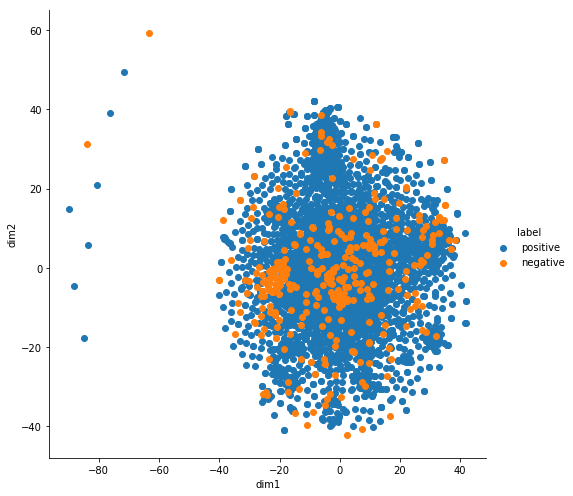

In [14]:
# visualising  
label=train['Score']
data=np.vstack((train_bow_tsne.T,label[:3000])).T
data=pd.DataFrame(data,columns=['dim1','dim2','label'])

g=sn.FacetGrid(data, hue='label',height=7)
g.map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

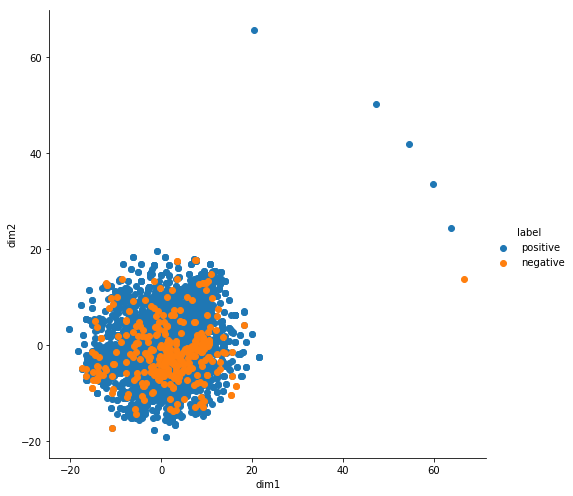

In [15]:
# converting sparse matrix of train_bow into dense matrix 

"""
n_components=2
perplexity=40.0
n_iter=1000"""

# taking default parameter of tsne but always run tsne with multiple times using different parameter
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, perplexity=40.0, n_iter=1000 ) 
train_bow_tsne=tsne.fit_transform(dense_train_bow[:3000])

# visualising  
label=train['Score']
data=np.vstack((train_bow_tsne.T,label[:3000])).T
data=pd.DataFrame(data,columns=['dim1','dim2','label'])

g=sn.FacetGrid(data, hue='label',height=7)
g.map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

##### conclusion TSNE on BOW(unigram)
* All the negative points are laying over positive points
* We are not able to linearly seperate negative points from positive points
* The density of negative points are more in the center. 
* The spreadness of postive points are more
* Apply TSNE on other text vectors to compare


#### 2. TSNE on TF-IDF(unigram)

In [24]:
# converting sparse matrix of train_tf_idf into dense matrix 
dense_train_tf_idf=train_tf_idf[:3000].todense()

"""
n_components=2
perplexity=30.0
n_iter=1000"""

# taking default parameter of tsne but always run tsne with multiple times using different parameter
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, perplexity=30.0, n_iter=1000 ) 
train_tf_idf_tsne=tsne.fit_transform(dense_train_tf_idf)

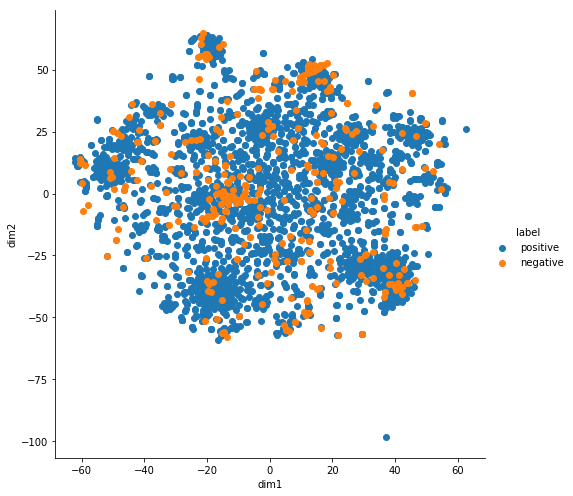

In [27]:
# visualising  
label=train['Score']
data=np.vstack((train_tf_idf_tsne.T,label[:3000])).T
data=pd.DataFrame(data,columns=['dim1','dim2','label'])

g=sn.FacetGrid(data, hue='label',height=7)
g.map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

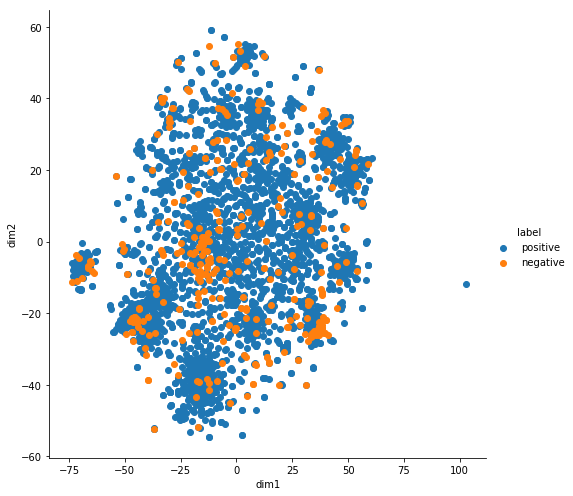

In [16]:
# converting sparse matrix of train_tf_idf into dense matrix 
dense_train_tf_idf=train_tf_idf[:3000].todense()

"""
n_components=2
perplexity=40.0
n_iter=1000"""

# taking default parameter of tsne but always run tsne with multiple times using different parameter
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, perplexity=40.0, n_iter=1000 ) 
train_tf_idf_tsne=tsne.fit_transform(dense_train_tf_idf)

# visualising  
label=train['Score']
data=np.vstack((train_tf_idf_tsne.T,label[:3000])).T
data=pd.DataFrame(data,columns=['dim1','dim2','label'])

g=sn.FacetGrid(data, hue='label',height=7)
g.map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

###### conclusion TSNE on TF-IDF(unigram)
* The seperation between positive class and negative class are clearer than TSNE on Bow
* Still, we are not able to lineary seperate positive class and negative class 
* Try TSNE with different featurizer and compare

#### 3. TSNE on avg w2v

In [ ]:
"""
n_components=2
perplexity=30.0
n_iter=1000"""


# taking default parameter of tsne but always run tsne with multiple times using different parameter
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, perplexity=30.0, n_iter=1000 ) 
train_w2v_tsne=tsne.fit_transform(train_w2v[:3000])

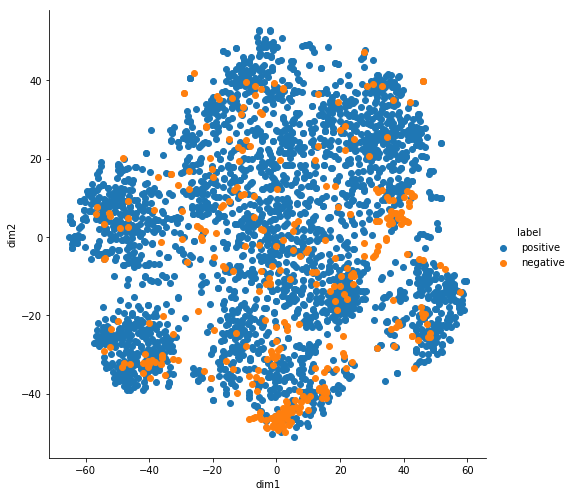

In [17]:
# visualising  
label=train['Score']
data=np.vstack((train_w2v_tsne.T,label[:3000])).T
data=pd.DataFrame(data,columns=['dim1','dim2','label'])

g=sn.FacetGrid(data, hue='label',height=7)
g.map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

In [ ]:

"""
n_components=2
perplexity=40.0
n_iter=1000"""

# taking default parameter of tsne but always run tsne with multiple times using different parameter
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, perplexity=40.0, n_iter=1000 ) 
train_w2v_tsne=tsne.fit_transform(train_w2v[:3000])

# visualising  
label=train['Score']
data=np.vstack((train_w2v_tsne.T,label[:3000])).T
data=pd.DataFrame(data,columns=['dim1','dim2','label'])

g=sn.FacetGrid(data, hue='label',height=7)
g.map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

###### conclusion TSNE on avg w2v
* The TSNE plot is very close to 'TSNE on Tf-Idf' but run time is comparatevely faster than TSNE Tf-Idf.
* We are not able to seperate postive class and negative class clearly

#### 4. TSNE on tf-idf w2v

In [15]:

"""
n_components=2
perplexity=30.0
n_iter=1000"""

# taking default parameter of tsne but always run tsne with multiple times using different parameter
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, perplexity=30.0, n_iter=1000 ) 
train_tf_idf_w2v_tsne=tsne.fit_transform(train_tf_idf_w2v[:3000])

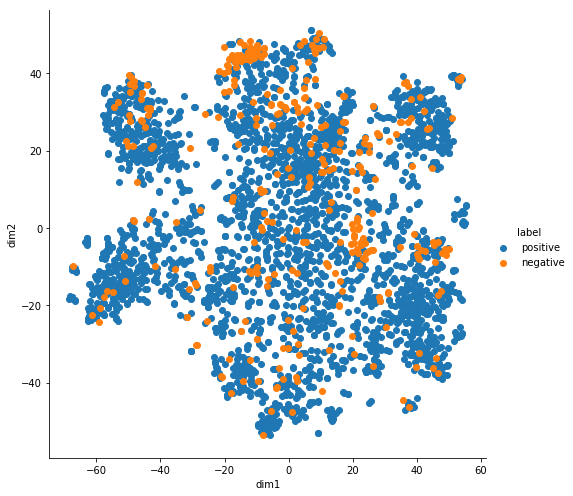

In [17]:
# visualising  
label=train['Score']
data=np.vstack((train_tf_idf_w2v_tsne.T,label[:3000])).T
data=pd.DataFrame(data,columns=['dim1','dim2','label'])

g=sn.FacetGrid(data, hue='label',height=7)
g.map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

In [ ]:
"""
n_components=2
perplexity=40.0
n_iter=1000"""


# taking default parameter of tsne but always run tsne with multiple times using different parameter
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, perplexity=40.0, n_iter=1000 ) 
train_tf_idf_w2v_tsne=tsne.fit_transform(train_tf_idf_w2v[:3000])

# visualising  
label=train['Score']
data=np.vstack((train_tf_idf_w2v_tsne.T,label[:3000])).T
data=pd.DataFrame(data,columns=['dim1','dim2','label'])

g=sn.FacetGrid(data, hue='label',height=7)
g.map(plt.scatter,'dim1','dim2').add_legend()
plt.show()

###### conclusion TSNE on tf-idf w2v
* Again, The visualisation of TSNE on 'Tf-Idf avg w2v' is also close to TSNE on Tf-Idf but run time is comparatevely faster than Tf-Idf.
* We are not able to seperate postive class and negative class clearly.

## conclusion on TSNE plot
* we can see that clsses are imbalance therefore majority class is showing dominace over minority class in plot
* positive class and negative class are overlaping
* positive and negative datapoints are not linearly seperable


##### Hence if want to make inference and seperation between positive class and negative better we need to apply ML classification model and then compare the result